# Notebook content

## Inlcude standard libraries

In [ ]:
# Standard libraries
import math
import os
import random
import time
import urllib.request
from functools import partial
from urllib.error import HTTPError
from types import SimpleNamespace

# PyTorch Lightning
import lightning as L
from lightning.pytorch.loggers import TensorBoardLogger

# Plotting
import matplotlib
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import seaborn as sns

from mpl_toolkits.axes_grid1 import ImageGrid
from PIL import Image

# Libraries for ML
import numpy as np
import pandas as pd

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import random_split, Dataset, DataLoader
from torchvision.transforms import v2 as tforms
import torchmetrics

# Torchvision
import torchvision
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint
from torchvision import transforms
from tqdm.notebook import tqdm

## Set paths, seed for random stuffs, etc

In [ ]:
import os 
import numpy as np
import pandas as pd
TEST_DATASET_PATH = os.environ.get("PATH_TEST_DATASETS", "/kaggle/input/plant-seedlings-classification/test")

### Kaggle path

In [ ]:
# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = os.environ.get("PATH_DATASETS", "/kaggle/input/plant-seedlings-classification")
TRAIN_DATASET_PATH = os.environ.get("PATH_TRAIN_DATASETS", "/kaggle/input/plant-seedlings-classification/train")
TEST_DATASET_PATH = os.environ.get("PATH_TEST_DATASETS", "/kaggle/input/plant-seedlings-classification/test")

# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = os.environ.get("PATH_CHECKPOINT", "/kaggle/working")
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

num_workers = os.cpu_count()

### Google Colab path

In [ ]:

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = os.environ.get("PATH_DATASETS", "/kaggle/input/plant-seedlings-classification")
TRAIN_DATASET_PATH = os.environ.get("PATH_TRAIN_DATASETS", "/kaggle/input/plant-seedlings-classification/train")
TEST_DATASET_PATH = os.environ.get("PATH_TEST_DATASETS", "/kaggle/input/plant-seedlings-classification/test")

# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = os.environ.get("PATH_CHECKPOINT", "./saved_models/")
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

num_workers = os.cpu_count()

### Local Repo path

In [ ]:
# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = os.environ.get("PATH_DATASETS", "./data")
TRAIN_DATASET_PATH = os.environ.get("PATH_TRAIN_DATASETS", "./data/train")
TEST_DATASET_PATH = os.environ.get("PATH_TEST_DATASETS", "./data/test")

# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = os.environ.get("PATH_CHECKPOINT", "./saved_models/")
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

num_workers = int(os.cpu_count()/ 2)

In [ ]:
plt.set_cmap("cividis")
%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg", "pdf")  # For export
matplotlib.rcParams["lines.linewidth"] = 2.0
sns.reset_orig()

# Setting the seed
seed = 13
L.seed_everything(seed)
# Ensure that all operations are deterministic on GPU (if used) for reproducibility\
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

#os.environ["CUBLAS_WORKSPACE_CONFIG"]=":4096:8"

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)


Seed set to 13


Device: cuda:0


In [ ]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

## Do data engineering

In [ ]:
def make_fname_class_df(train_dir):
    classes = os.listdir(train_dir)

    file_lst = []
    class_lst = []
    class_idx_lst = []
    for i, cl in enumerate(classes):
        path = train_dir + f"/{cl}"
        file_lst = file_lst + os.listdir(path)
        class_lst = class_lst + [cl]* len(os.listdir(path))
        class_idx_lst = class_idx_lst + [i]* len(os.listdir(path))
    full_df = pd.DataFrame({"file": file_lst, "class": class_lst,\
                              "class_idx": class_idx_lst})
    return full_df

full_df = make_fname_class_df(TRAIN_DATASET_PATH)

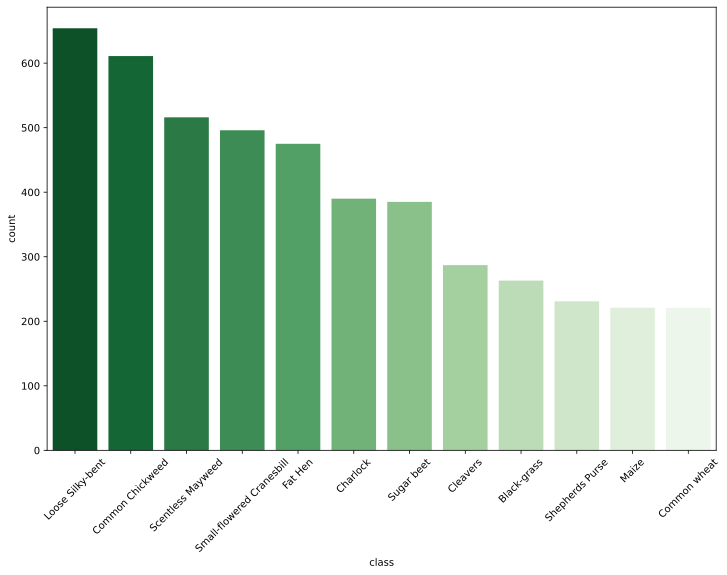

In [ ]:
plt.figure(figsize=(12, 8))
g = sns.countplot(data=full_df, x="class", order=full_df['class'].value_counts().index, palette='Greens_r')
plt.xticks(rotation=45);

In [ ]:
def visualize_input_images(root_dir, images_per_row=7):
    classes = os.listdir(root_dir)
    fig = plt.figure(1, figsize=(len(classes)*3, images_per_row*3))
    grid = ImageGrid(fig, 111, nrows_ncols=(len(classes), images_per_row), axes_pad=0.05)
    for (row, class_name) in enumerate(classes):
        path = root_dir + f"/{class_name}"
        image_fname_samples = random.sample(os.listdir(path),k=images_per_row)
        for img_fname, col in zip(image_fname_samples, range(images_per_row)):
            img_path = root_dir + f"/{class_name}" + f"/{img_fname}"
            img = Image.open(img_path).convert("RGB").resize((224, 224))
            grid[row*images_per_row + col].imshow(img)
            grid[row*images_per_row + col].set_axis_off()
            if col == images_per_row - 1:
                grid[row*images_per_row + col].text(250, 110, class_name, verticalalignment='bottom', horizontalalignment="left")

visualize_input_images(TRAIN_DATASET_PATH)

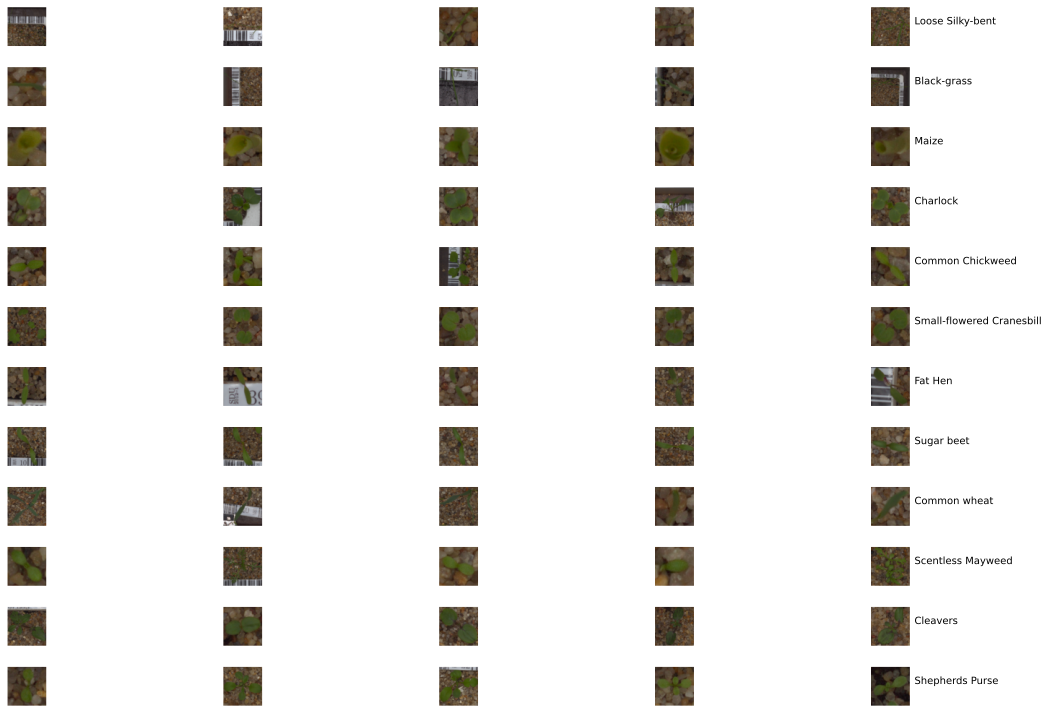

In [ ]:
def visualize_input_images_2(root_dir, images_per_row=5):
    classes = os.listdir(root_dir)
    fig, axes = plt.subplots(nrows=len(classes), ncols=images_per_row, figsize=(15, 10))
    fig.tight_layout(pad=0.0)
    for (row, class_name) in enumerate(classes):
        path = root_dir + f"/{class_name}"
        image_fname_samples = random.sample(os.listdir(path),k=images_per_row)
        for img_fname, col in zip(image_fname_samples, range(images_per_row)):
            img_path = root_dir + f"/{class_name}" + f"/{img_fname}"
            img = Image.open(img_path).convert("RGB").resize((224, 224))
            axes[row][col].imshow(img)
            axes[row][col].set_axis_off()
            if col == images_per_row - 1:
                axes[row][col].text(250, 110, class_name, verticalalignment='bottom', horizontalalignment="left")

visualize_input_images_2(TRAIN_DATASET_PATH)

## Create datamodule

In [ ]:
from torch.utils.data import random_split, Dataset, DataLoader
class PlantTrainDataset(Dataset):

    def __init__(self, root_dir, transform=None, target_transform=None):
        self.root_dir = root_dir
        self.fname_class_df = make_fname_class_df(root_dir)
        self.transform = transform
        self.target_transform = target_transform

    # def class_to_idx(self):
    #     return {_class: i for i, _class in enumerate(self.classes)}

    # def idx_to_class(self):
    #     return dict(zip(range(len(self.classes)), self.classes))

    def __len__(self):
        return self.fname_class_df.shape[0]

    def __getitem__(self, idx):
        path = self.root_dir + f"/{self.fname_class_df.loc[self.fname_class_df.index[idx], 'class']}" \
            + f"/{self.fname_class_df.loc[self.fname_class_df.index[idx], 'file']}"
        image = Image.open(path).convert("RGB")
        target = self.fname_class_df.loc[self.fname_class_df.index[idx], "class_idx"]

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            target = self.target_transform(target)
        return image, target

class PlantTestDataset(Dataset):

    def __init__(self, root_dir, transform=None, target_transform=None):
        self.root_dir = root_dir
        self.fname_class_df = pd.DataFrame({"file": os.listdir(root_dir)})
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return self.fname_class_df.shape[0]

    def __getitem__(self, idx):
        path = self.root_dir + f"/{self.fname_class_df.loc[self.fname_class_df.index[idx], 'file']}"
        image = Image.open(path).convert("RGB")

        if self.transform:
            image = self.transform(image)
        return image

In [ ]:
def compute_mean_std(dataset, batch_size=8):
    #imgage values in [0, 255]
    rgb_values = torch.cat([img.reshape(3, -1) for img, target in dataset], dim=-1)
    rgb_values_chunks = rgb_values.split(224*224*batch_size, dim=1)
    rgb_mean_chunks = [torch.mean(chunk.float(), dim=-1) for chunk in rgb_values_chunks] #list of tensor shape (3,)
    rgb_mean = torch.mean(torch.stack(rgb_mean_chunks, dim=0), dim=0).reshape((3, 1)) #shape (3, 1)

    rgb_var_chunks = [torch.mean((chunk - rgb_mean).float()** 2, dim=-1) for chunk in rgb_values_chunks]
    rgb_std = torch.sqrt(torch.mean(torch.stack(rgb_var_chunks, dim=0), dim=0))

    return rgb_mean.squeeze()/ 255.0, rgb_std/ 255.0

In [ ]:
class PlantDataModule(L.LightningDataModule):
    def __init__(self, root_dir, test_dir, batch_size):
        super().__init__()
        self.root_dir = root_dir
        self.test_dir = test_dir
        self.batch_size = batch_size
        backbone_mean, backbone_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

        self.transform = tforms.Compose([
            tforms.ToImage(),
            tforms.ToDtype(torch.uint8, scale=True),
            tforms.RandomAffine(degrees=10, translate=(0.2, 0.2)),
            tforms.RandomHorizontalFlip(),
            tforms.RandomVerticalFlip(),
            tforms.Resize((224, 224), antialias=True),
            tforms.ToDtype(torch.float32, scale=True),
            tforms.Normalize(backbone_mean, backbone_std)
        ])
        self.test_transform = tforms.Compose([
            tforms.ToImage(),
            tforms.ToDtype(torch.uint8, scale=True),
            tforms.Resize((224, 224), antialias=True),
            tforms.ToDtype(torch.float32, scale=True),
            tforms.Normalize(backbone_mean, backbone_std)
        ])

    def prepare_data(self):
        # download
        pass

    def setup(self, stage: str):
        if stage == "fit":
            full_dataset = PlantTrainDataset(self.root_dir,transform=self.transform)
            
            self.train_dataset, self.val_dataset = random_split(full_dataset, [0.8, 0.2],\
                generator=torch.Generator().manual_seed(seed)
            )
        if stage == "test":
            full_dataset = PlantTrainDataset(self.root_dir,transform=self.transform)
            
            _, self.test_dataset = random_split(full_dataset, [0.8, 0.2],\
                generator=torch.Generator().manual_seed(torch.initial_seed())
            )
        if stage == "predict":
            self.predict_dataset = PlantTestDataset(self.test_dir, transform=self.test_transform)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, drop_last=False,\
                    num_workers=num_workers, pin_memory=True, worker_init_fn=seed_worker,\
                    generator=torch.Generator().manual_seed(torch.initial_seed()), persistent_workers=True
        )

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, drop_last=False,\
                    num_workers=num_workers, worker_init_fn=seed_worker,\
                    generator=torch.Generator().manual_seed(torch.initial_seed()), persistent_workers=True
        )

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, drop_last=False,\
                    num_workers=num_workers, worker_init_fn=seed_worker,\
                    generator=torch.Generator().manual_seed(torch.initial_seed()), persistent_workers=True
        )

    def predict_dataloader(self):
        return DataLoader(self.predict_dataset, batch_size=self.batch_size, shuffle=False, drop_last=False,\
                    num_workers=num_workers, worker_init_fn=seed_worker,\
                    generator=torch.Generator().manual_seed(torch.initial_seed()), persistent_workers=True
        )
